# Image recognition with TTR


## Bridging between perceptual and conceptual domains

Let's apply the object detection representation proposed in Dobnik & Cooper's *Interfacing language, spatial perception and cognition in TTR* to image recognition.

![Fig 8](fig/lspc-fig8.png)

Here, we use `Image` instead of `PointMap` for the whole, but instead of `reg:PointMap` we use yet another type (and rename it), `seg:Segment`. In Cooper's case the same type can be used to represent both the region and the whole, because a `PointMap` is a set of absolute positions. With `Image`, positions are relative to an origin, which needs to be specified when cropping.

I guess in the general case, the domain of an `ObjectDetector` function need not be the same as the `reg` fields in the output elements.

In [1]:
import sys
sys.path.append('pyttr')
from pyttr.ttrtypes import *
from pyttr.utils import *
import PIL.Image

ttrace()

# Basic types.

Ind = BType('Ind')

Int = BType('Int')
Int.learn_witness_condition(lambda x: isinstance(x, int))
print(Int.query(365))

Image = BType('Image')
Image.learn_witness_condition(lambda x: isinstance(x, PIL.Image.Image))
img = PIL.Image.open('res/dogbike.jpg') # Source: https://www.nps.gov/dena/planyourvisit/pets.htm
print(Image.query(img))

# Segment type: a rectangular area of a given image.

Segment = RecType({'cx': Int, 'cy': Int, 'w': Int, 'h': Int})
print(Segment.query(Rec({'cx': 100, 'cy': 150, 'w': 40, 'h': 20})))

# Redefine Image.show() to work with Rec.show().
def image_show(self):
    return str(self)
PIL.Image.Image.show = image_show
show(img)

True
True
True


'<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=700x437 at 0x7FCADC5A6898>'

In [2]:
def latex(*objs):
    texcode = '\n\n'.join(to_ipython_latex(obj) for obj in objs)
    #print(texcode)
    return Latex(texcode)

$Ind$ and $Image$ are basic types.

$Segment = \left[\begin{array}{rcl}
\text{cx} &:& Int\\
\text{cy} &:& Int\\
\text{w} &:& Int\\
\text{h} &:& Int\\
\end{array}\right]$

$Ppty = (Ind \rightarrow Type)$

* $\left( \lambda x : Ind . dog(x) \right) : Ppty$
* $a : Ind$
* $(\lambda x : Ind . dog(x))(a) = dog(a) : Type$

$Object = \left[ \begin{array}{rcl}
    \text{pfun} &:& Ppty \\
    \text{seg} &:& Segment \\
\end{array} \right]$

$ObjectDetector = ( Image \rightarrow [Object] )$

In [3]:
Ppty = FunType(Ind, Ty)
Object = RecType({'seg': Segment, 'pfun': Ppty})
Objects = ListType(Object)
ObjectDetector = FunType(Image, Objects)

latex(Segment, Ppty, ObjectDetector)

<IPython.core.display.Latex object>

In [4]:
# Custom PyTTR utilities

from functools import reduce
    
def copy_rectype(T):
    R = RecType()
    for k, v in T.comps.__dict__.items():
        R.addfield(k, v)
    return R

def rectype_relabels(T, rlbs):
    for k1, k2 in rlbs.items():
        T.Relabel(k1, k2)
    return T

def rectype_merges(Ts):
    return reduce((lambda T, U: T.merge(U)), Ts, RecType())

def is_basic_type(T):
    tn = lambda T: type(T).__name__
    return (tn(T) == 'BType') if tn(T) != 'SingletonType' else is_basic_type(T.comps.base_type)

def basic_fields(T):
    return [k for k, v in T.comps.__dict__.items() if is_basic_type(v)]

def nonbasic_fields(T):
    return [k for k, v in T.comps.__dict__.items() if not is_basic_type(v)]

ptypes = dict()
def mkptype(sym, types=[Ind], vars=['v']):
    """Make preds and ptypes identifiable by their predicate names."""
    id = '/'.join([sym, ','.join(show(type) for type in types), ','.join(vars)])
    if id not in ptypes:
        ptypes[id] = PType(Pred(sym, types), vars)
    return ptypes[id]

def create_fun(pred_name, vars=['a']):
    """Create a function of a given number (length of vars) of Inds."""
    fun = mkptype(pred_name, types=[Ind]*len(vars), vars=vars)
    for v in reversed(vars):
        fun = Fun(v, Ind, fun)
    return fun

# print(show(create_fun('bamba', 'abcd')))

## Object detection model YOLO

We use an object detection model to detect and recognize objects in an image. The output is modeled as a set of TTR records.

Requires OpenCV and [Darkflow](https://github.com/thtrieu/darkflow). `yolo.weights` is from [Yolo](https://pjreddie.com/darknet/yolo/).

In [5]:
# Instantiate YOLO.

from darkflow.net.build import TFNet

tfnet = TFNet({"model": "yolo/yolo.cfg", "load": "yolo/yolo.weights",
    'config': 'yolo', "threshold": 0.1})

Parsing yolo/yolo.cfg
Loading yolo/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.026572465896606445s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +b

In [6]:
# Function to apply YOLO to a given image.

import numpy as np

yolo_out = dict()
def yolo(img):
    if str(img) not in yolo_out:
        yolo_out[str(img)] = tfnet.return_predict(np.array(img))
    return yolo_out[str(img)]

def yolo_coords(o, quadruple=False):
    """Extract the coordinates from a YOLO output item as ((x0,y0), (x1,y1)) or (x0, y0, x1, y1)."""
    coords = (o['topleft']['x'], o['topleft']['y']), (o['bottomright']['x'], o['bottomright']['y'])
    return coords[0] + coords[1] if quadruple else coords

y = yolo(img)
print(yolo_coords(y[0]))

((423, 2), (594, 381))


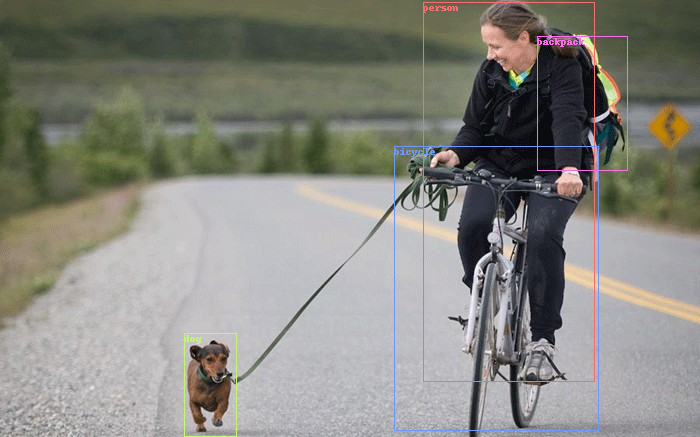

In [7]:
from PIL import ImageFont, ImageDraw
from IPython.display import display

# Generate distinguishable colors.
phi = 2 / (1 + 5 ** .5)
colors = ('hsl({}, 90%, 70%)'.format(int(x * 360)) for x in count(0, phi))

def yolo_annotate(img):
    img_annotated = img.copy()
    draw = ImageDraw.Draw(img_annotated)
    for o in yolo(img):
        color = next(colors)
        draw.rectangle(yolo_coords(o), outline=color)
        draw.text(yolo_coords(o)[0], o['label'], fill=color)
    display(img_annotated)
    
yolo_annotate(img)

In [8]:
def xy1xy2_to_cwh(x1, y1, x2, y2):
    '''Transform to center, width and height.'''
    return {'cx': int(x1/2 + x2/2), 'cy': int(y1/2 + y2/2), 'w': x2 - x1, 'h': y2 - y1}

In [9]:
def yolo_detector(i):
    return [Rec({
        'seg': Rec(xy1xy2_to_cwh(*yolo_coords(o, True))),
        'pfun': create_fun(o['label'].replace(' ', '_')),
        
    }) for o in yolo(i)] # @todo RBG/BGR?
ObjectDetector.witness_cache.append(yolo_detector)

objs = yolo_detector(img)

print(ObjectDetector.query(yolo_detector))
print(Objects.query(objs))
print(Object.query(objs[0]))
print(Ppty.query(objs[0].pfun))
print(Segment.query(objs[0].seg))

latex(objs)

True
True
True
True
True


<IPython.core.display.Latex object>

## Individualization function

The object detection model gave us evidence that certain segments contain something that present certain properties/classes.

Now let's recognize that there are individuals which are located at those segments and having those properties. ("Basic relationships" in Logan & Sadler (1996)).

**Is the domain of $Individualize$ really objects *of type* $IndObj$? Can a record type be *of* another record type?**

$IndObj = \left[\begin{array}{rcl}
\text{x} &:& Ind\\
\text{cp} &:& Type\\
\text{cl} &:& Type\\
\text{loc} &:& Type\\
\end{array}\right]$?

$Individualize : (Object \rightarrow IndObj)$ or $(Object \rightarrow Type)$ or $(Object \rightarrow RecType)$?

$Individualize = \lambda r : Object\ . \left[\begin{array}{rcl}
    \text{x} &:& Ind \\
    \text{cp} &:& r.\text{pfun}(\text{x}) \\
    \text{cl} &:& \text{location}(\text{x}, \text{loc}) \\
    \text{loc} &:& Segment_{r.\text{seg}}\\
\end{array}\right]$

or the "instantiating" version:

$Individualize' = \lambda r : Object\ . \left[\begin{array}{lcl}
    \text{x} = a_0 &:& Ind \\
    \text{cp} = prf_0 &:& r.\text{pfun}(\text{x}) \\
    \text{cl} = prf_1 &:& \text{location}(\text{x}, \text{loc}) \\
    \text{loc} = r.\text{seg} &:& Segment\\
\end{array}\right]$

**TODO** Is the range of Individualize really IndObj? Or RecType?

**TODO** Don't use gensym() below, because it breaks field label agreement with the IndObj type.

In [10]:
LocFun = create_fun('location', 'ab')

IndObj = RecType({
    'x' : Ind,
    'loc' : Type,
    'cp' : Type,
    'cl' : Type,
})

def individualize(r):
    x = gensym('x')
    loc = gensym('loc')
    return RecType({
        x: Ind,
        gensym('cp'): r.pfun.app(x),
        loc: SingletonType(Segment, r.seg),
        gensym('cl'): LocFun.app(x).app(LazyObj([loc])),
    })

print(IndObj.query(individualize(objs[1])))
latex(list(individualize(obj) for obj in objs))


False


<IPython.core.display.Latex object>

## Combining commitments

All observed situations are combined into one, so they can be considered simultaneously.

In [11]:
from functools import reduce
situations = [individualize(r) for r in objs]
sitmerge = rectype_merges(situations)
latex(sitmerge)

<IPython.core.display.Latex object>

## Spatial relations

Classify two $IndObj$s as $\text{left}$:

$\lambda r :
\left[\begin{array}{rcl}
    \text{trg}&:&\left[\begin{array}{rcl}
        \text{x}&:&Ind\\
        \text{loc}&:&Segment\\
        \text{cl}&:&location(\text{x},\text{loc})
    \end{array}\right]\\
    \text{ref}&:&\left[\begin{array}{rcl}
        \text{x}&:&Ind\\
        \text{loc}&:&Segment\\
        \text{cl}&:&location(\text{x},\text{loc})
    \end{array}\right]\\
\end{array}\right]
.
\begin{cases}
\left[\begin{array}{lcl}
    \text{trg}=r.\text{trg}.\text{x} &:& Ind\\
    \text{ref}=r.\text{ref}.\text{x} &:& Ind\\
    \text{c} &:& \text{left}(\text{trg}, \text{ref})\\
\end{array}\right]
&
\begin{array}{l}
    \text{if } \kappa_{left}(r.\text{trg}.\text{loc}, r.\text{ref}.\text{loc}) \\
\end{array}\\
[] & \text{otherwise}
\end{cases}
$

In [12]:
from itertools import product

location_relation_classifiers = {
    'left': lambda a, b: a.cx < b.cx,
    'right': lambda a, b: a.cx > b.cx,
    'above': lambda a, b: a.cy < b.cy,
    'below': lambda a, b: a.cy > b.cy,
}

def get_locs(T):
    locs = dict()
    for c in nonbasic_fields(T):
        t = T.comps.__dict__[c]
        if isinstance(t, PType) and t.comps.pred.name == 'location':
            locs[t.comps.args[0]] = t.comps.args[1]
    return locs

def detect_relations(T, classifiers):
    locs = get_locs(T)
    rels = []
    for k, f in classifiers:
        for x1, x2 in product(locs, locs):
            if f(locs[x1], locs[x2]):
                rels.append(create_fun(k, 'ab').app(x1).app(x2))
    return rels
    
rels = detect_relations(sitmerge, location_relation_classifiers.items())
sitmergerels = rectype_merges([sitmerge] + [RecType({gensym('rel'): rel}) for rel in rels])
latex(sitmergerels)

AttributeError: 'str' object has no attribute 'cy'

## Text parsing

In [13]:
import nltk

# Parsing to PyTTR cannot really be done directly. NLTK feature grammars support strings and FOPC. Variable substitution
# is only allowed in FOPC, so we produce a mix of both.
# - String: comma-separated list of record type fields.
# - FOPC expression: conjunction of ptypes, for each of which we create a new field.
grammar = nltk.grammar.FeatureGrammar.fromstring(r'''
%start S
S[SEM=<?s(x) & ?vp(x, y)>] -> NP[SEM=?s] VP[SEM=?vp]
NP[SEM=<?det(?n)>] -> Det[SEM=?det] N[SEM=?n]
Det[SEM=<\P a.P(a)>] -> 'a' | 'an'
N[SEM=<dog>] -> 'dog'
N[SEM=<car>] -> 'car'
N[SEM=<person>] -> 'person'
N[SEM=<bicycle>] -> 'bicycle'
N[SEM=<backpack>] -> 'backpack'
VP[SEM=?pp] -> 'is' PP[SEM=?pp]
PP[SEM=<\a b.(?prep(a, b) & ?o(b))>] -> Prep[SEM=?prep] NP[SEM=?o]
Prep[SEM=<left>] -> 'to' 'the' 'left' 'of'
Prep[SEM=<right>] -> 'to' 'the' 'right' 'of'
Prep[SEM=<above>] -> 'above'
Prep[SEM=<under>] -> 'under'
''')
parser = nltk.FeatureChartParser(grammar)

texts = [
    'A dog is to the left of a bicycle',
]

def fopc_to_pyttr(expr, T=RecType()):
    """Turns a FOPC object into a RecType."""
    from nltk.sem.logic import ApplicationExpression, AndExpression
    if isinstance(expr, ApplicationExpression):
        pred, args = expr.uncurry()
        T.addfield(gensym('c'), mkptype(str(pred), vars=[str(a) for a in args]))
        for x in args:
            if str(x) not in T.comps.__dict__:
                T.addfield(str(x), Ind)
    if isinstance(expr, AndExpression):
        fopc_to_pyttr(expr.first, T)
        fopc_to_pyttr(expr.second, T)
    return T

def eng_to_pyttr(text):
    trees = parser.parse(text.lower().split())
    sem = nltk.sem.root_semrep(list(trees)[0])
    T = fopc_to_pyttr(sem)
    return T

print(texts[0])
latex(eng_to_pyttr(texts[0]))

A dog is to the left of a bicycle


<IPython.core.display.Latex object>

## Checking text against image

Essentially, we would like to check if the situation observed is a subtype of the situation described by the text/question, whether $Q \sqsupseteq A$. A new problem here is that field labels do not match, even if the field values (the types) match. We thus need to consider all (?) relabelings of Q:

A record type $T_1$ is a *relabel-subtype* of $T_2$ if there is a relabeling of $T_1$, $T_{1_{rlb}}$ where $T_{1_{rlb}} \sqsubseteq T_2$.

Could we forget field labels and just look at the two sets of field values? Not really, because we have dependent types, so $\text{dog}(x_1) ≠ \text{dog}(x_2)$. We need to carry out each candidate *relabeling* and check subtypeness. In practice, and in this case, relabeling the basic-type ($Ind$) fields is enough, because those are the only ones whose labels appear in dependent fields. For each basic-field relabeling, we can then kind of forget labels and just find subtypeness of field values.

In [14]:
from itertools import permutations, combinations

def find_subtype_relabeling(T, U):
    '''Could record type T be a sub type of record type U if relabeling in T is allowed?'''
    # Find possible relabelings for basic-type fields
    basic_label_permutations = set(ps[:len(basic_fields(U))] for ps in permutations(basic_fields(T)))
    
    for tks in basic_label_permutations:
        # Copy U and try a basic-fields relabeling
        U2 = copy_rectype(U)
        rlb = dict(zip(basic_fields(U), tks))
        rectype_relabels(U2, rlb)
        
        # For each U field, find a T field that is a subtype
        match = dict()
        for uk in nonbasic_fields(U2):
            for tk in nonbasic_fields(T):
                if T.comps.__dict__[tk].subtype_of(U2.comps.__dict__[uk]):
                    match[uk] = tk
                    break
            if uk not in match:
                break

        # Successful if all non-basic fields match.
        if len(match) == len(nonbasic_fields(U2)):
            return dict(**rlb, **match)
    return None

obs = sitmergerels
r = eng_to_pyttr(texts[0])
print(find_subtype_relabeling(obs, r))
r2 = rectype_relabels(copy_rectype(r), find_subtype_relabeling(obs, r))
print(obs.subtype_of(r2))
latex(r2)

NameError: name 'sitmergerels' is not defined